In [1]:
%load_ext autoreload
%autoreload 2
    
import os, sys
#PWD = os.getenv('PWD')
PWD = '/Users/chris/Documents/lab/emAnalysis/backend/server'

PROJ_MISSING_MSG = """Set an enviroment variable:\n
`DJANGO_PROJECT=your_project_name`\n
or call:\n
`init_django(your_project_name)`
"""

def init_django(project_name=None):
    os.chdir(PWD)
    project_name = project_name or os.environ.get('DJANGO_PROJECT') or None
    if project_name == None:
        raise Exception(PROJ_MISSING_MSG)
    sys.path.insert(0, os.getenv('PWD'))
    os.environ.setdefault('DJANGO_SETTINGS_MODULE', f'{project_name}.settings')
    os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
    import django
    django.setup()

init_django("server")
from django.conf import settings
media_root = settings.MEDIA_ROOT
import numpy as np
import os
from matplotlib import pyplot as plt
import functools
import math
import sims
import copy
import cv2
import os
from PIL import Image
from pathlib import Path
import numpy as np
from skimage.measure import regionprops
from scipy import spatial
import pickle
from matplotlib.figure import Figure
import pyvips
from image.models import Image
from core.models import Canvas
from mims.models import MIMSImage, MIMSImageSet
from PIL import Image
from scipy.ndimage import rotate
import pprint
import sims
import SimpleITK as sitk
import tifffile
import imageio

In [2]:
import json
from django.shortcuts import get_object_or_404
from mims.services.unwarp import create_unwarped_composites
from mims.services.orient_images import largest_inner_square
from mims.services.registration_utils import (
    create_composite_mask,
    create_mask_from_shapes,
    scale_between_masks,
    test_mask_iou,
)
from mims.model_utils import (
    get_autocontrast_image_path,
    get_concatenated_image,
)
from mims.models import Isotope, MIMSAlignment, MIMSImage
import os
from pathlib import Path
import cv2
from PIL import Image
import numpy as np
from mims.services import unwarp_image

MASK_PADDING = 20

def match_masks(em_mask, mims_mask, reg_loc):
    scale_diff = 1
    orig_iou, orig_translation = test_mask_iou(em_mask, mims_mask)

    # Make an image with both masks, where one set is
    # first test the scale if needed: take furthest points and calculate distances
    # Get bounding box of 1s for each mask
    furthest_points_scale = scale_between_masks(em_mask, mims_mask)
    print("Furthest points scale test", furthest_points_scale)
    # Scale the em mask and test the iou
    em_mask_test = cv2.resize(
        em_mask,
        (
            int(em_mask.shape[1] / furthest_points_scale),
            int(em_mask.shape[0] / furthest_points_scale),
        ),
    )
    scaled_iou, scaled_translation = test_mask_iou(em_mask_test, mims_mask)

    em_to_use = em_mask
    translation_to_use = orig_translation
    if scaled_iou > orig_iou:
        print("scaled is better")
        em_to_use = em_mask_test
        translation_to_use = scaled_translation
        scale_diff *= furthest_points_scale

    em_to_use = np.array(em_to_use)
    # Pad the em if translation means it exceeds the bounds
    lpad = max(0, -translation_to_use[0])
    rpad = max(0, translation_to_use[0] + mims_mask.shape[1] - em_to_use.shape[1])
    tpad = max(0, -translation_to_use[1])
    bpad = max(0, translation_to_use[1] + mims_mask.shape[0] - em_to_use.shape[0])
    em_to_use = np.pad(em_to_use, ((tpad, bpad), (lpad, rpad)))
    em_to_use = em_to_use[
        max(0, translation_to_use[1]) : mims_mask.shape[0]
        + max(0, translation_to_use[1]),
        max(0, translation_to_use[0]) : mims_mask.shape[1]
        + max(0, translation_to_use[0]),
    ]
    # Pad both 20px so the dewarping can be done without worrying about the edges
    em_to_use = np.pad(em_to_use, MASK_PADDING, mode="constant", constant_values=0)
    mims_mask_padded = np.pad(
        mims_mask, MASK_PADDING, mode="constant", constant_values=0
    )

    # Translate the em mask to match the mims mask
    composite_mask = create_composite_mask(em_to_use, mims_mask_padded)
    Image.fromarray(em_to_use).save(os.path.join(reg_loc, "em_mask_for_unwarp.tiff"))
    Image.fromarray(mims_mask_padded).save(
        os.path.join(reg_loc, "mims_mask_for_unwarp.tiff")
    )
    Image.fromarray(composite_mask).save(
        os.path.join(reg_loc, "composite_mask_translated.png")
    )
    # plt imshow the em_to_use
    plt.imshow(em_to_use)

    return (scale_diff, translation_to_use)


def register_images(mims_image_obj_id):
    mims_image = get_object_or_404(MIMSImage, pk=mims_image_obj_id)
    mims_path = Path(mims_image.file.path)
    print(f"Registering images for {mims_image}")
    reg_loc = os.path.join(mims_path.parent, mims_path.stem)
    with open(os.path.join(reg_loc, "registration", "reg_shapes.json"), "r") as f:
        json_shapes = json.load(f)
    em_shapes = json_shapes["em_shapes"]
    mims_shapes = json_shapes["mims_shapes"]

    # Update the alignment in the database
    old_alignment = mims_image.alignments.filter(status="USER_ROUGH_ALIGNMENT").first()

    # Load the original images
    mims_path = Path(mims_image.file.path)
    reg_loc = os.path.join(mims_path.parent, mims_path.stem)
    em_img = np.array(Image.open(os.path.join(reg_loc, "registration", "em.png")))
    mims_img = np.array(Image.open(os.path.join(reg_loc, "isotopes", "32S.png")))

    # Create binary masks from polygons
    em_mask_orig = create_mask_from_shapes(em_img.shape[:2], em_shapes)
    mims_mask = create_mask_from_shapes(mims_img.shape[:2], mims_shapes)
    new_scale, new_translation = match_masks(em_mask_orig, mims_mask, reg_loc)
    updated_scale = new_scale * old_alignment.scale
    # Refind the translated EM we're using - easier than trying to
    # back-calculate it
    if new_scale:
        em_img = cv2.resize(
            em_img,
            (
                int(em_img.shape[1] / new_scale),
                int(em_img.shape[0] / new_scale),
            ),
        )
    lpad = max(0, -new_translation[0])
    rpad = max(0, new_translation[0] + mims_mask.shape[1] - em_img.shape[1])
    tpad = max(0, -new_translation[1])
    bpad = max(0, new_translation[1] + mims_mask.shape[0] - em_img.shape[0])
    em_img = np.pad(em_img, ((tpad, bpad), (lpad, rpad)))
    em_img = em_img[
        max(0, new_translation[1]) : mims_mask.shape[0] + max(0, new_translation[1]),
        max(0, new_translation[0]) : mims_mask.shape[1] + max(0, new_translation[0]),
    ]

    em_img = Image.fromarray(em_img)
    # Then do the transformations to it
    em_img = em_img.rotate(-old_alignment.rotation_degrees, expand=True)
    if old_alignment.flip_hor:
        em_img = em_img.transpose(Image.FLIP_LEFT_RIGHT)
    # Scale it up
    em_img = Image.fromarray(
        cv2.resize(
            np.array(em_img),
            (int(em_img.width * updated_scale), int(em_img.height * updated_scale)),
        )
    )
    plt.imshow(em_img)

    # Calculate the cropping box
    largest_inner_square_side = int(
        largest_inner_square(em_img.width, old_alignment.rotation_degrees)
    )
    center_x, center_y = em_img.width // 2, em_img.height // 2
    start_x = center_x - largest_inner_square_side // 2
    start_y = center_y - largest_inner_square_side // 2
    end_x = center_x + largest_inner_square_side // 2
    end_y = center_y + largest_inner_square_side // 2
    amount_to_adjust = (em_img.height - (end_y - start_y)) // 2
    em_to_find = Image.fromarray(np.array(em_img)[start_y:end_y, start_x:end_x])

    full_em = np.array(Image.open(mims_image.image_set.canvas.images.first().file.path))

    search_buffer = int(mims_mask.shape[0] * updated_scale * 0.3)
    em_search_coords = [
        old_alignment.y_offset - search_buffer,
        old_alignment.y_offset
        + int(mims_mask.shape[0] * updated_scale)
        + search_buffer * 2,
        old_alignment.x_offset - search_buffer,
        old_alignment.x_offset
        + int(mims_mask.shape[1] * updated_scale)
        + search_buffer * 2,
    ]
    lpad = max(0, -em_search_coords[2])
    rpad = max(0, em_search_coords[3] - full_em.shape[1])
    tpad = max(0, -em_search_coords[0])
    bpad = max(0, em_search_coords[1] - full_em.shape[0])
    search_padding = ((tpad, bpad), (lpad, rpad))
    em_to_search = np.pad(full_em, search_padding)
    em_to_search = em_to_search[
        em_search_coords[0] + tpad : em_search_coords[1] + tpad,
        em_search_coords[2] + lpad : em_search_coords[3] + lpad,
    ]
    # match template
    em_to_search = np.array(em_to_search)
    result = cv2.matchTemplate(
        em_to_search, np.asarray(em_to_find), cv2.TM_CCOEFF_NORMED
    )
    _, _, _, max_loc = cv2.minMaxLoc(result)
    # Adjust back from the box search thing
    max_loc = [r - amount_to_adjust for r in max_loc]
    new_x_offset = em_search_coords[2] + max_loc[0] - int(MASK_PADDING * updated_scale)
    new_y_offset = em_search_coords[0] + max_loc[1] - int(MASK_PADDING * updated_scale)

    # Save the new alignment
    mims_image.alignments.filter(status="FINAL_TWEAKED_ONE").delete()
    alignment = MIMSAlignment.objects.create(
        mims_image=mims_image,
        x_offset=new_x_offset,
        y_offset=new_y_offset,
        rotation_degrees=old_alignment.rotation_degrees,
        flip_hor=old_alignment.flip_hor,
        scale=updated_scale,
        status="FINAL_TWEAKED_ONE",
        info={
            "padding": MASK_PADDING,
        },
    )
    alignment.save()
    print("starting unwarping")
    #mims_image.status = "DEWARPING"
    #mims_image.save()
    #unwarp_image(mims_image)
    #mims_image.status = "DEWARPED_ALIGNED"
    #mims_image.save()
    print("done unwarping")
    # Check if the imageset is complete
    #create_unwarped_composites(mims_image.image_set.id, full_em_shape=full_em.shape)
    print("done creating unwarped composites")


def get_images_from_alignment(mims_img_obj, full_em, save=True):
    mims_image = get_object_or_404(MIMSImage, pk=mims_img_obj)
    mims_path = Path(mims_image.file.path)
    alignment = mims_image.alignments.filter(status="FINAL_TWEAKED_ONE").first()
    reg_loc = os.path.join(mims_path.parent, mims_path.stem)

    # test if the em_image and mims_image can be re-calculated from the available info
    mims = np.array(Image.open(get_autocontrast_image_path(mims_image, "SE")))
    mims = np.pad(mims, alignment.info["padding"], mode="constant", constant_values=0)
    mims = Image.fromarray(mims)
    if alignment.flip_hor:
        mims = mims.transpose(Image.FLIP_LEFT_RIGHT)
    mims = mims.rotate(alignment.rotation_degrees, expand=True)
    mims = mims.resize(
        (int(mims.width * alignment.scale), int(mims.height * alignment.scale)),
    )
    mims = np.array(mims)
    if save:
        Image.fromarray(mims).save(os.path.join(reg_loc, "mims_cropped.png"))

    tpad = max(0, -alignment.y_offset)
    bpad = max(0, alignment.y_offset + mims.shape[0] - full_em.shape[0])
    lpad = max(0, -alignment.x_offset)
    rpad = max(0, alignment.x_offset + mims.shape[1] - full_em.shape[1])
    full_em = np.pad(full_em, ((tpad, bpad), (lpad, rpad)))

    cropped_em = full_em[
        max(0, alignment.y_offset) : max(0, alignment.y_offset) + mims.shape[0],
        max(0, alignment.x_offset) : max(0, alignment.x_offset) + mims.shape[1],
    ]

    if save:
        Image.fromarray(cropped_em).save(os.path.join(reg_loc, "em_cropped.png"))

    fig, axs = plt.subplots(2, 1, figsize=(10, 20))
    axs[0].imshow(full_em, cmap='gray')
    axs[0].set_title("Full EM Image with Registered Area")
    rect = plt.Rectangle((alignment.x_offset, alignment.y_offset), mims.shape[1], mims.shape[0], 
                         linewidth=2, edgecolor='r', facecolor='none')
    axs[0].add_patch(rect)
    axs[1].imshow(cropped_em, cmap='gray')
    axs[1].set_title("Cropped EM Image")
    axs[1].imshow(mims, cmap='hot', alpha=0.5)
    plt.show()
    
    return

Registering images for mims_image_sets/a9e56535-98eb-4916-b5ff-a7f860d8aa53/mims_images/1035_position_1.im
Furthest points scale test 0.994531772917871
starting unwarping
done unwarping
done creating unwarped composites
Registering images for mims_image_sets/a9e56535-98eb-4916-b5ff-a7f860d8aa53/mims_images/1035_position_2.im
Furthest points scale test 1.041531277907243
starting unwarping
done unwarping
done creating unwarped composites
Registering images for mims_image_sets/a9e56535-98eb-4916-b5ff-a7f860d8aa53/mims_images/1035_position_3.im
Furthest points scale test 1.0450325779623066
starting unwarping
done unwarping
done creating unwarped composites
Registering images for mims_image_sets/6827ceba-8393-484a-acf6-9895b8ec8a22/mims_images/1035_position_4.im
Furthest points scale test 1.0005524315787337
scaled is better
starting unwarping
done unwarping
done creating unwarped composites
Registering images for mims_image_sets/6827ceba-8393-484a-acf6-9895b8ec8a22/mims_images/1035_position

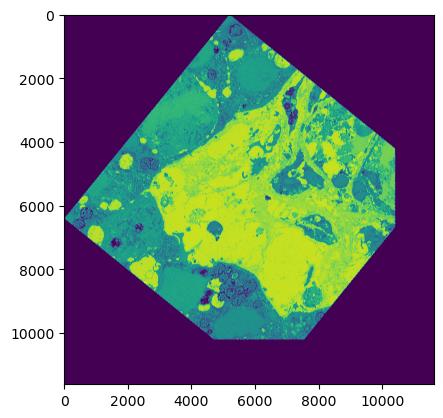

In [3]:
run_ids = ["a9e56535-98eb-4916-b5ff-a7f860d8aa53", "6827ceba-8393-484a-acf6-9895b8ec8a22", 
           "26cd4511-27b2-4cdf-91b2-163350f67d48",
"43fe2edd-3e82-4750-a3a9-b37eb2ea2ae7", "cad88dc6-fa71-41e6-a599-32a548833600", 
"a0f88677-a698-4ca8-ab06-a89c23a9efd7", "0e91fcde-bd6f-47bd-a04c-a8a992334f87",
"a39e4a37-04d0-4268-81f1-1ec124985363"
]
for run_id in run_ids:
    image_set = MIMSImageSet.objects.get(id=run_id)
    for mimage in image_set.mims_images.all():
        if mimage.status != "DEWARPED_ALIGNED":
            continue
        register_images(mimage.id)
        #get_images_from_alignment(mimage.id, full_em, save=False)
    create_unwarped_composites(image_set.id, full_em_shape=np.array(Image.open(image_set.canvas.images.first().image.file)).shape)

In [41]:
# For 1hr fasting mice, info.txt
"""*er - liver msHu august2024/retrained w/15vs40/er_vlong 15 v 40 - 0.97 
er2 - nov2023 er master/er v2 weights final
er3 - nov 2023 er master /er v1  verylongrun
glycogen - liver glycogen cd cr v2/cd cr brian v2
*glycogen2 - liver glycogen good - 0.999
*mito - feb 2024/ liver mito master - 0.98
mito2 - liver mito segmentation good/
*ld - liver_ld_segmentation_good/august master good final 0.9"""

# Organize the cells into Aliyah's format
def organize_canvas(canvas, name):
    base_out = os.path.join("/Users/chris/Documents/lab/remote_shuttle/1hr", name, "ROI1")

    imageset = canvas.mims_sets.first()
    print(imageset.id)
    em_img = np.array(Image.open(canvas.images.first().image.file))
    cells_img = np.array(Image.open(Path(
      os.path.join(settings.MEDIA_ROOT, "mims_image_sets", str(imageset.id), "composites", "cells.tiff")
    )))
    nuclei_img = np.array(Image.open(Path(
      os.path.join(settings.MEDIA_ROOT, "mims_image_sets", str(imageset.id), "composites", "nuclei.tiff")
    )))
    # Make the nuclei img binary
    nuclei_img = nuclei_img > 0

    img_13c_ratio = np.array(Image.open(Path(
      os.path.join(settings.MEDIA_ROOT, "mims_image_sets", str(imageset.id), "composites", "unwarped_isotopes", "13C12C_ratio.tiff")
    )))

    mito_dir = "/Volumes/Chris_SSD/file_shuttle/mito"
    mito_file = os.path.join(mito_dir, [f for f in os.listdir(mito_dir) if f"processed_{name}" in f][0])
    if not Path(mito_file).exists():
        raise Exception("Mito file not found")
    mito_img = np.array(Image.open(mito_file))
    mito_img = mito_img > 0.98

    er_dir = "/Volumes/Chris_SSD/file_shuttle/er"
    er_file = os.path.join(er_dir, [f for f in os.listdir(er_dir) if f"processed_{name}" in f][0])
    if not Path(er_file).exists():
        raise Exception("ER file not found")
    er_img = np.array(Image.open(er_file))
    er_img = er_img > 0.97

    glycogen_dir = "/Volumes/Chris_SSD/file_shuttle/glycogen"
    glycogen_file = os.path.join(glycogen_dir, [f for f in os.listdir(glycogen_dir) if f"processed_{name}" in f][0])
    if not Path(glycogen_file).exists():
        raise Exception("Glycogen file not found")
    glycogen_img = np.array(Image.open(glycogen_file))
    glycogen_img = glycogen_img > 0.999

    ld_dir = "/Volumes/Chris_SSD/file_shuttle/ld"
    ld_file = os.path.join(ld_dir, [f for f in os.listdir(ld_dir) if f"processed_{name}" in f][0])
    if not Path(ld_file).exists():
        raise Exception("LD file not found")
    ld_img = np.array(Image.open(ld_file))
    ld_img = ld_img > 0.9
    
    cell_ct = np.max(cells_img)
    for cell_num in range(1, cell_ct + 1):
        cell_mask = cells_img == cell_num
        # Find the bounding box
        rows = np.any(cell_mask, axis=1)
        cols = np.any(cell_mask, axis=0)
        ymin, ymax = np.where(rows)[0][[0, -1]]
        xmin, xmax = np.where(cols)[0][[0, -1]]

        # Crop to the bounding box
        cell_mask_crop = cell_mask[ymin:ymax+1, xmin:xmax+1]
        em_crop = em_img[ymin:ymax+1, xmin:xmax+1]
        em_crop = np.where(cell_mask_crop, em_crop, 0).astype(np.uint8)
        nuclei_crop = nuclei_img[ymin:ymax+1, xmin:xmax+1]
        nuclei_crop = np.pad(nuclei_crop, ((0, cell_mask_crop.shape[0] - nuclei_crop.shape[0]), (0, cell_mask_crop.shape[1] - nuclei_crop.shape[1])), mode="constant", constant_values=0)
        nuclei_crop = np.where(cell_mask_crop, nuclei_crop*255, 0).astype(np.uint8)
        img_13c_crop = img_13c_ratio[ymin:ymax+1, xmin:xmax+1]

        img_13c_crop = np.where(cell_mask_crop, img_13c_crop, 0).astype(np.uint16)
        zero_count = np.sum((img_13c_crop == 0) & cell_mask_crop)
        total_count = np.sum(cell_mask_crop)
        zero_percentage = (zero_count / total_count) * 100
        print("Cell num:", cell_num, "Zero pct:", zero_percentage)
        if zero_percentage > 8:
            print("Skipping this one, too high of a zero percentage for 13C")
            continue
        img_13c_crop = np.where((img_13c_crop == 0) & cell_mask_crop, 110, img_13c_crop).astype(np.uint16)

        mito_crop = mito_img[ymin:ymax+1, xmin:xmax+1]
        mito_crop = np.where(cell_mask_crop, mito_crop*255, 0).astype(np.uint8)
        er_crop = er_img[ymin:ymax+1, xmin:xmax+1]
        er_crop = np.where(cell_mask_crop, er_crop*255, 0).astype(np.uint8)
        glycogen_crop = glycogen_img[ymin:ymax+1, xmin:xmax+1]
        glycogen_crop = np.where(cell_mask_crop, glycogen_crop*255, 0).astype(np.uint8)
        ld_crop = ld_img[ymin:ymax+1, xmin:xmax+1]
        ld_crop = np.where(cell_mask_crop, ld_crop*255, 0).astype(np.uint8)
        # Save the images
        cell_dir = os.path.join(base_out, f"cell_{str(cell_num)}")
        os.makedirs(os.path.join(cell_dir, "Final_Outputs"), exist_ok=True)
        tifffile.imwrite(os.path.join(cell_dir, f"EM_cell{str(cell_num)}.tiff"), em_crop)
        tifffile.imwrite(os.path.join(cell_dir, f"X13C_cell{str(cell_num)}.tiff"), img_13c_crop)
        tifffile.imwrite(os.path.join(cell_dir, f"NUCLEUS_cell{str(cell_num)}.tiff"), nuclei_crop)
        tifffile.imwrite(os.path.join(cell_dir, f"MITO_cell{str(cell_num)}.tiff"), mito_crop)
        tifffile.imwrite(os.path.join(cell_dir, f"ER_cell{str(cell_num)}.tiff"), er_crop)
        tifffile.imwrite(os.path.join(cell_dir, f"Glycogen_cell{str(cell_num)}.tiff"), glycogen_crop)
        tifffile.imwrite(os.path.join(cell_dir, f"LD_cell{str(cell_num)}.tiff"), ld_crop)
    return
  
canvas = Canvas.objects.get(id="f5c084c9-4fec-47a2-a3f4-340ecf1e94bc")
organize_canvas(canvas, "M4")

cafc510b-45ea-4798-b30c-869e0bb706ba
Cell num: 1 Zero pct: 0.0
Cell num: 2 Zero pct: 2.779417659451905
Cell num: 3 Zero pct: 1.6533800282084348
Cell num: 4 Zero pct: 3.7475838644017982
Cell num: 5 Zero pct: 0.0
Cell num: 6 Zero pct: 0.0
Cell num: 7 Zero pct: 2.8696998223994132
Cell num: 8 Zero pct: 1.2185943854969721e-05
Cell num: 9 Zero pct: 0.6659505552187991
Cell num: 10 Zero pct: 0.13706685543897595
Cell num: 11 Zero pct: 11.733345023654245
Skipping this one, too high of a zero percentage for 13C
Cell num: 12 Zero pct: 5.616468186174604
Cell num: 13 Zero pct: 4.813361214927914
Cell num: 14 Zero pct: 3.0417469159990214
Cell num: 15 Zero pct: 0.577343604362956
Cell num: 16 Zero pct: 8.685503676601135
Skipping this one, too high of a zero percentage for 13C
Cell num: 17 Zero pct: 0.0
Cell num: 18 Zero pct: 0.0
Cell num: 19 Zero pct: 8.250109690501501
Skipping this one, too high of a zero percentage for 13C
Cell num: 20 Zero pct: 0.2627476347480553


In [10]:
from core.models import Canvas
def create_masked_em(canvas):
    # Get the canvas EM obj
    em_obj = canvas.images.first()
    # Load the image
    em_img = np.array(Image.open(em_obj.file.path))
    # Get the edges of the MIMS area using the SE composite image
    imageset = canvas.mims_sets.first()
    composite_SE_path = os.path.join(settings.MEDIA_ROOT, "mims_image_sets", str(imageset.id), 
                                        "composites", "unwarped_isotopes", "SE.tiff")
    composite_SE = np.array(Image.open(composite_SE_path))
    # Get the bounding box of the SE image
    props = regionprops(composite_SE)
    # Make everything outside the bounding box 0
    mask = np.zeros_like(em_img)
    top, left, bottom, right = props[0].bbox
    mask[top:bottom, left:right] = 1
    masked_img = em_img * mask
    # Save the masked image
    outpath = os.path.join(settings.MEDIA_ROOT, "mims_image_sets", str(imageset.id), 
                                        "composites", "masked_em_to_mims.tiff")
    #Image.fromarray(masked_img).save(outpath)

for canvas in Canvas.objects.all():
    if "1hr" in canvas.name:
        continue
        # create_masked_em(canvas)
        


In [57]:
import os
from pathlib import Path

def delete_files_by_name(folder_path, target_filename):
    # Convert to Path object for easier path management
    folder_path = Path(folder_path)
    
    # Walk through all subdirectories and files
    for root, _, files in os.walk(folder_path):
        for file_name in files:
            # Check if the file name matches the target
            if file_name == target_filename:
                file_path = Path(root) / file_name
                try:
                    file_path.unlink()  # Delete the file
                    print(f"Deleted: {file_path}")
                except Exception as e:
                    print(f"Failed to delete {file_path}: {e}")


folder = "/Users/chris/Documents/lab/emAnalysis/backend/server/media/mims_image_sets/"
delete_files_by_name(folder, "em_to_search.png")
delete_files_by_name(folder, "em_cropped2.png")
delete_files_by_name(folder, "composite_mask_translated.png")
delete_files_by_name(folder, "composite_mask_unwarped.png")

Deleted: /Users/chris/Documents/lab/emAnalysis/backend/server/media/mims_image_sets/0e91fcde-bd6f-47bd-a04c-a8a992334f87/mims_images/1037_position_2/em_to_search.png
Deleted: /Users/chris/Documents/lab/emAnalysis/backend/server/media/mims_image_sets/0e91fcde-bd6f-47bd-a04c-a8a992334f87/mims_images/1037_position_3/em_to_search.png
Deleted: /Users/chris/Documents/lab/emAnalysis/backend/server/media/mims_image_sets/0e91fcde-bd6f-47bd-a04c-a8a992334f87/mims_images/1037_position_4/em_to_search.png
Deleted: /Users/chris/Documents/lab/emAnalysis/backend/server/media/mims_image_sets/0e91fcde-bd6f-47bd-a04c-a8a992334f87/mims_images/1037_position_1/em_to_search.png
Deleted: /Users/chris/Documents/lab/emAnalysis/backend/server/media/mims_image_sets/6827ceba-8393-484a-acf6-9895b8ec8a22/mims_images/1035_position_5/em_to_search.png
Deleted: /Users/chris/Documents/lab/emAnalysis/backend/server/media/mims_image_sets/6827ceba-8393-484a-acf6-9895b8ec8a22/mims_images/1035_position_4/em_to_search.png
Dele

In [ ]:
import os
from pathlib import Path
import shutil


folder = "/Users/chris/Documents/lab/emAnalysis/backend/server/media/mims_image_sets/"
